# Student GPA Prediction Model

This notebook contains an enhanced version of the student GPA prediction model with feature engineering, improved neural network architecture, and model evaluation.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load and Explore Data

In [14]:
# Load the CSV files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Check data shapes
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Check missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())

# Display first few rows
print("\nFirst 5 rows of training data:")
display(train_df.head())

Training data shape: (1530, 14)
Test data shape: (383, 14)

Missing values in training data:
StudentID              0
Age                    0
Gender                 0
Ethnicity              0
ParentalEducation    142
StudyTimeWeekly        0
Absences               0
Tutoring               0
ParentalSupport      132
Extracurricular        0
Sports                 0
Music                  0
Volunteering           0
GPA                    0
dtype: int64

First 5 rows of training data:


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,3321,17,1,Caucasian,High School,9.906353,25,0,High,1,1,0,0,1.082390
1,1160,18,0,Caucasian,High School,4.681156,20,0,High,0,0,0,1,1.189549
2,2644,16,0,Other,Some College,6.845312,13,0,NaN,0,0,1,0,1.852672
3,2321,18,0,Asian,High School,19.885760,2,0,High,1,0,0,0,3.517237
4,2419,15,1,African American,Bachelor,14.806261,20,0,Very High,0,0,0,0,1.582093


## 2. Feature Engineering & Data Preprocessing

In [15]:
# Define features
numerical_features = ['Age', 'StudyTimeWeekly', 'Absences']
categorical_features = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 
                       'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

# Handle missing values
train_df.fillna({feature: train_df[feature].mean() for feature in numerical_features}, inplace=True)
test_df.fillna({feature: test_df[feature].mean() for feature in numerical_features}, inplace=True)

train_df.dropna(subset=categorical_features, inplace=True)
test_df.dropna(subset=categorical_features, inplace=True)

# Feature engineering - create new features
# 1. Study-Age Interaction 
train_df['Study_Age_Interaction'] = train_df['StudyTimeWeekly'] * train_df['Age']
test_df['Study_Age_Interaction'] = test_df['StudyTimeWeekly'] * test_df['Age']

# 2. Study Time Squared (non-linear relationship)
train_df['StudyTimeSquared'] = train_df['StudyTimeWeekly'] ** 2
test_df['StudyTimeSquared'] = test_df['StudyTimeWeekly'] ** 2

# 3. Activity Count (participation in activities)
activity_columns = ['Extracurricular', 'Sports', 'Music', 'Volunteering']
train_df['ActivityCount'] = train_df[activity_columns].apply(lambda row: row.sum(), axis=1)
test_df['ActivityCount'] = test_df[activity_columns].apply(lambda row: row.sum(), axis=1)

# Update numerical features list with new engineered features
numerical_features = ['Age', 'StudyTimeWeekly', 'Absences', 
                     'Study_Age_Interaction', 'StudyTimeSquared', 'ActivityCount']

print("Features after engineering:")
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

# Split the data
X = train_df.drop('GPA', axis=1)
y = train_df['GPA']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"\nProcessed training data shape: {X_train_processed.shape}")


Features after engineering:
Numerical features: ['Age', 'StudyTimeWeekly', 'Absences', 'Study_Age_Interaction', 'StudyTimeSquared', 'ActivityCount']
Categorical features: ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

Processed training data shape: (1015, 30)


## 3. Improved Model Architecture

In [16]:
# Build improved model with regularization
model = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# Model summary
model.summary()

E0000 00:00:1741793772.968953   49061 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1741793772.970692   49061 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 96 (384.00 B)

## 4. Training with Early Stopping

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1522 - mae: 1.5026 - val_loss: 3.4359 - val_mae: 1.6185
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2006 - mae: 1.2298 - val_loss: 2.5404 - val_mae: 1.3737
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3817 - mae: 0.9326 - val_loss: 1.6383 - val_mae: 1.0827
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1093 - mae: 0.8492 - val_loss: 1.0423 - val_mae: 0.8482
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8229 - mae: 0.7020 - val_loss: 0.6778 - val_mae: 0.6717
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7533 - mae: 0.6737 - val_loss: 0.5319 - val_mae: 0.5834
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6725 - mae: 0.6354 - val_loss: 0.4147 - val_mae: 0.5039
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5557 - mae: 0.5609 - val_loss: 0.3309 - val_mae: 0.4390
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.589

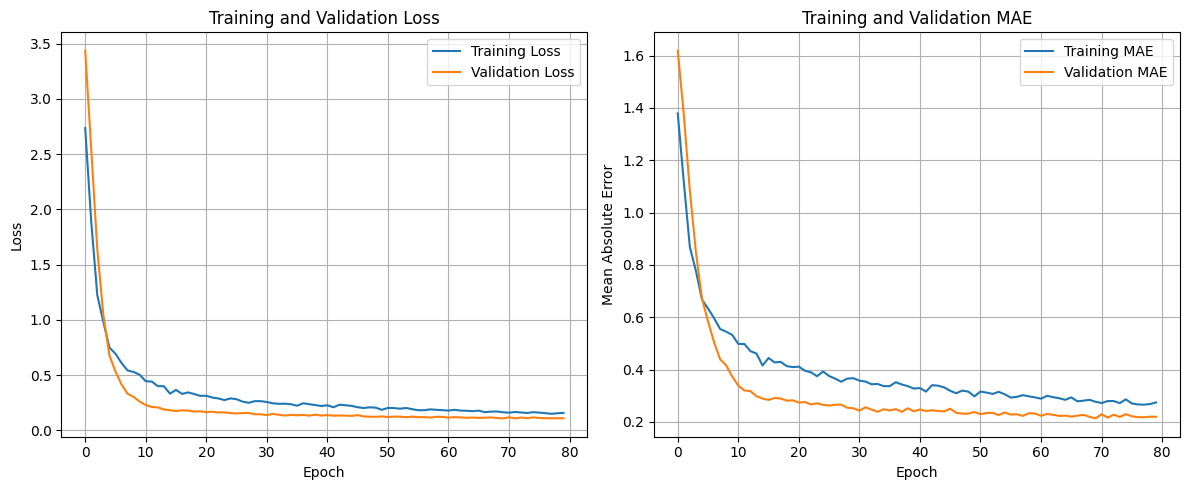

In [17]:
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_processed, y_train,
    epochs=150,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    batch_size=32,
    verbose=1
)

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Model Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation MSE: 0.0695
Validation RMSE: 0.2637
Validation R²: 0.9218


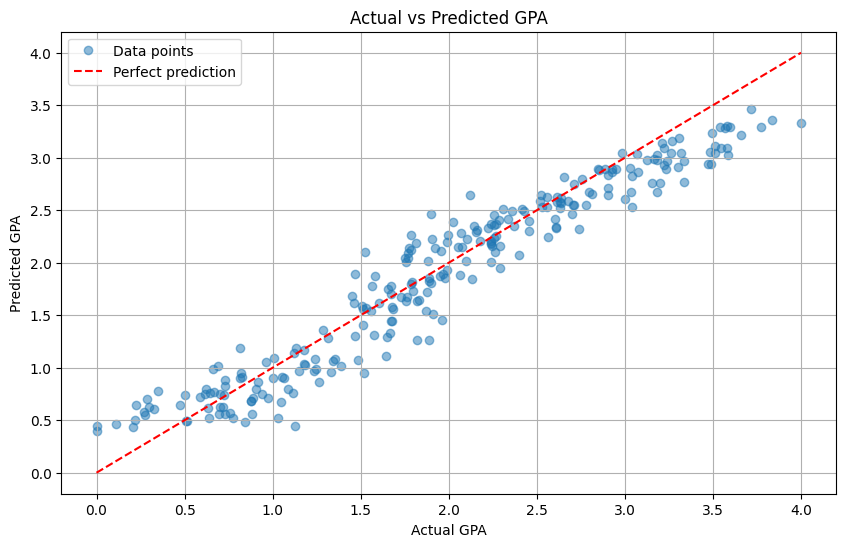

In [19]:
# Make predictions on validation set
val_predictions = model.predict(X_val_processed).flatten()

# Calculate metrics
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title('Actual vs Predicted GPA')
plt.plot([], [], 'o', color='C0', alpha=0.5, label='Data points')
plt.plot([], [], 'r--', label='Perfect prediction')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## 6. Generate Predictions on Test Data

In [20]:
# Process test data
if 'GPA' in test_df.columns:
    X_test = test_df.drop('GPA', axis=1)
else:
    X_test = test_df
    
X_test_processed = preprocessor.transform(X_test)

# Make predictions
test_predictions = model.predict(X_test_processed).flatten()

# Save predictions to CSV
output_df = pd.DataFrame({
    'StudentID': test_df['StudentID'], 
    'PredictedGPA': test_predictions
})
output_df.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")
print("\nSample predictions:")
display(output_df.head())

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions saved to 'predictions.csv'

Sample predictions:


,StudentID,PredictedGPA
0,2340,0.587295
1,2923,2.306383
2,2077,0.773811
3,2735,0.615376
4,2245,3.008217


## 7. Model Summary and Conclusion

### Improvements Made:

1. **Feature Engineering**:
   - Created Study-Age Interaction feature
   - Added StudyTimeSquared for non-linear relationships
   - Created ActivityCount to measure overall extracurricular involvement

2. **Model Architecture**:
   - Added L2 regularization to prevent overfitting
   - Implemented dropout layers for better generalization
   - Added batch normalization to stabilize training

3. **Training Procedure**:
   - Implemented early stopping to prevent overfitting
   - Used validation dataset to monitor model performance

4. **Model Evaluation**:
   - Used R² score and RMSE to evaluate performance
   - Visualized predictions vs. actual values

### Potential Future Improvements:

1. Try different model architectures (wider/deeper networks)
2. Experiment with learning rate schedules
3. Create more domain-specific features
4. Implement ensemble methods (combine predictions from multiple models)
5. Perform hyperparameter tuning with tools like Keras Tuner